#### **FEATURE ENGINEERING**
In this phase, we will transform the raw data into a more structured and informative form suitable for modeling Remaining Useful Life (RUL). The key steps include:

**Target Variable Construction (RUL)**:
A new feature, Remaining Useful Life (RUL), will be created as the difference between the maximum cycle for each engine and its current cycle. This variable will serve as the primary target for predictive modeling.

**Outlier Treatment**:
Outliers identified during the EDA—particularly in sensor measurements and operational settings—will be handled using appropriate statistical or transformation techniques. This step ensures that extreme values do not bias the model or distort learned relationships.

**Feature Reduction (Low-Variance Columns)**:
Columns exhibiting extremely low variability, as observed in the EDA, will be dropped. These features provide limited informational value, introduce redundancy, and may contribute noise, thereby reducing model efficiency and interpretability.

**Multicollinearity Handling**:
The correlation matrix from the EDA revealed strong correlations among several sensor measurements, indicating multicollinearity. To address this, correlated features will be carefully analyzed, and techniques such as feature selection or dimensionality reduction (e.g., Principal Component Analysis) will be applied to mitigate redundancy and improve model stability.

**Feature Scaling**:
All numerical features will be scaled (e.g., using Min-Max scaling or Standardization) to bring them into a comparable range. This step is crucial for algorithms sensitive to feature magnitudes, ensuring stable convergence and balanced influence of features during training.

In [61]:
 # import dependancies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [62]:
 # Setting up the visualization style 
sns.set_style( style = 'darkgrid' )
sns.set_palette( palette = 'icefire' )

In [ ]:
 # loading the dataset  
column_names = ['engine_id', 'cycle'] + \
               [f'operational_setting_{i}' for i in range(1, 4)] + \
               [f'sensor_measurement_{i}' for i in range(1, 22)]

rul_col_names = ['RUL']

 # Loading the train data
train_df_FD001 = pd.read_csv('train_FD001.txt', sep='\s+', header=None, names=column_names)
train_df_FD002 = pd.read_csv('train_FD002.txt', sep='\s+', header=None, names=column_names)
train_df_FD003 = pd.read_csv('train_FD003.txt', sep='\s+', header=None, names=column_names)
train_df_FD004 = pd.read_csv('train_FD004.txt', sep='\s+', header=None, names=column_names)

 # Loading the test data
test_df_FD001 = pd.read_csv('test_FD001.txt', sep='\s+', header=None, names=column_names)
test_df_FD002 = pd.read_csv('test_FD002.txt', sep='\s+', header=None, names=column_names)
test_df_FD003 = pd.read_csv('test_FD003.txt', sep='\s+', header=None, names=column_names)
test_df_FD004 = pd.read_csv('test_FD004.txt', sep='\s+', header=None, names=column_names)

 # Loading the RUL
RUL_df_FD001 = pd.read_csv('RUL_FD001.txt', sep='\s+', header=None, names=rul_col_names)
RUL_df_FD002 = pd.read_csv('RUL_FD002.txt', sep='\s+', header=None, names=rul_col_names)
RUL_df_FD003 = pd.read_csv('RUL_FD003.txt', sep='\s+', header=None, names=rul_col_names)
RUL_df_FD004 = pd.read_csv('RUL_FD004.txt', sep='\s+', header=None, names=rul_col_names)


In [76]:
 # Dataframes
test_dfs = { 
       'FD001':test_df_FD001, 
       'FD002':test_df_FD002, 
       'FD003':test_df_FD003, 
       'FD004':test_df_FD004
       }

train_dfs = {
       'FD001':train_df_FD001, 
       'FD002':train_df_FD002, 
       'FD003':train_df_FD003, 
       'FD004':train_df_FD004
}

RUL_dfs = {
    'FD001': RUL_df_FD001,
    'FD002': RUL_df_FD002,
    'FD003': RUL_df_FD003,
}

In [77]:
 # Adding RUL in the train df 
for name , df in train_dfs.items():
    max_cycles = df.groupby('engine_id')['cycle'].max().reset_index().rename(columns = {'engine_id' : 'engine_id' , 'cycle' : 'Max_cycle'})
    df = pd.merge( df, max_cycles, on = 'engine_id' )
    train_dfs[name] = df

for name , df in train_dfs.items():
    df['RUL'] = df['Max_cycle']-df['cycle']
    df = df.drop('Max_cycle', axis=1)
    train_dfs[name] = df


In [78]:
 # getting the statistical description of RUL
for name , df in train_dfs.items():
    display(df['RUL'].describe())

count    20631.000000
mean       107.807862
std         68.880990
min          0.000000
25%         51.000000
50%        103.000000
75%        155.000000
max        361.000000
Name: RUL, dtype: float64

count    53759.000000
mean       108.154746
std         69.180569
min          0.000000
25%         51.000000
50%        103.000000
75%        156.000000
max        377.000000
Name: RUL, dtype: float64

count    24720.000000
mean       138.077063
std         98.846675
min          0.000000
25%         61.000000
50%        123.000000
75%        190.000000
max        524.000000
Name: RUL, dtype: float64

count    61249.000000
mean       133.311417
std         89.783389
min          0.000000
25%         61.000000
50%        122.000000
75%        190.000000
max        542.000000
Name: RUL, dtype: float64

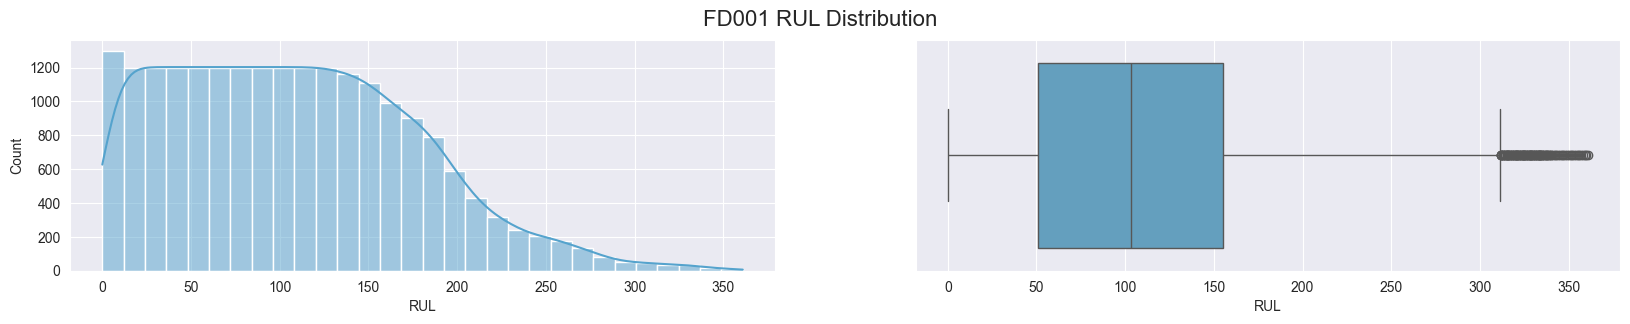

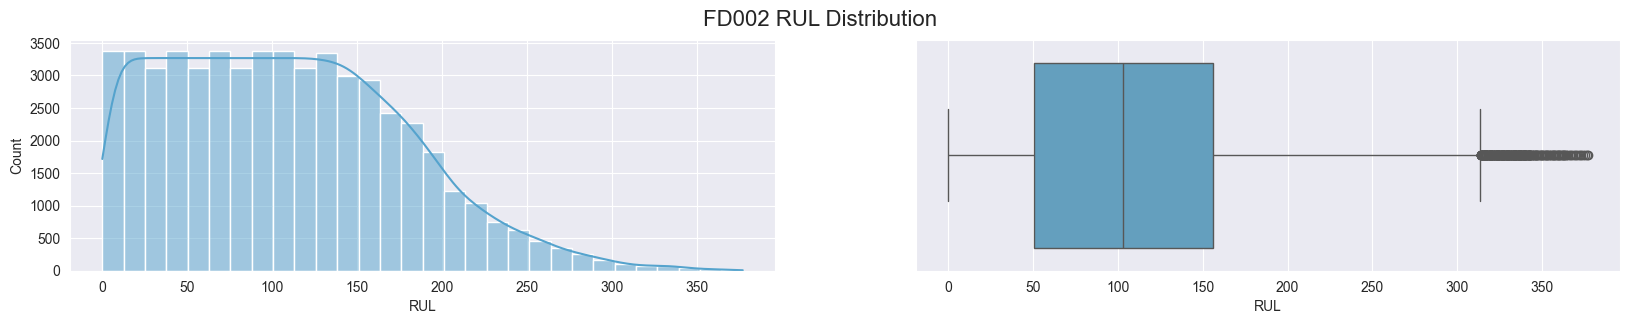

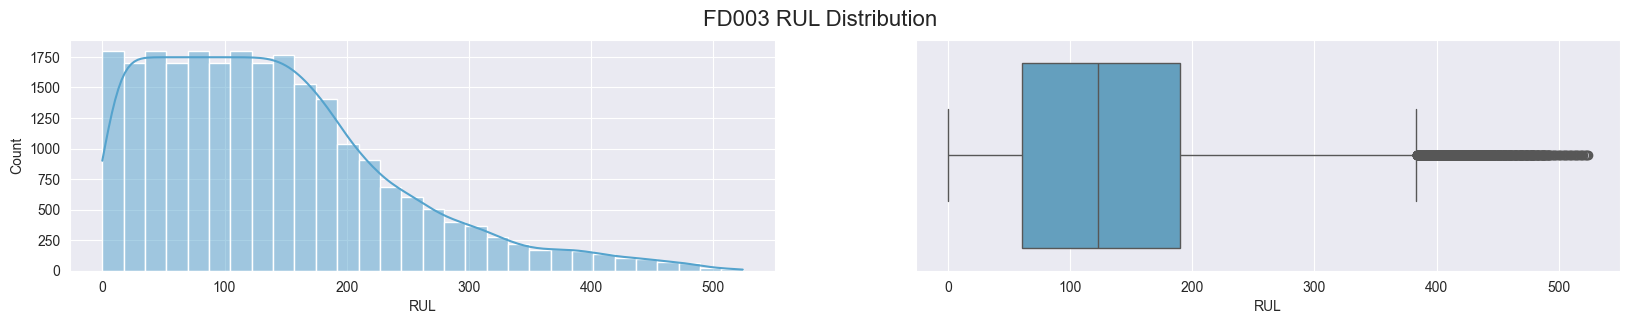

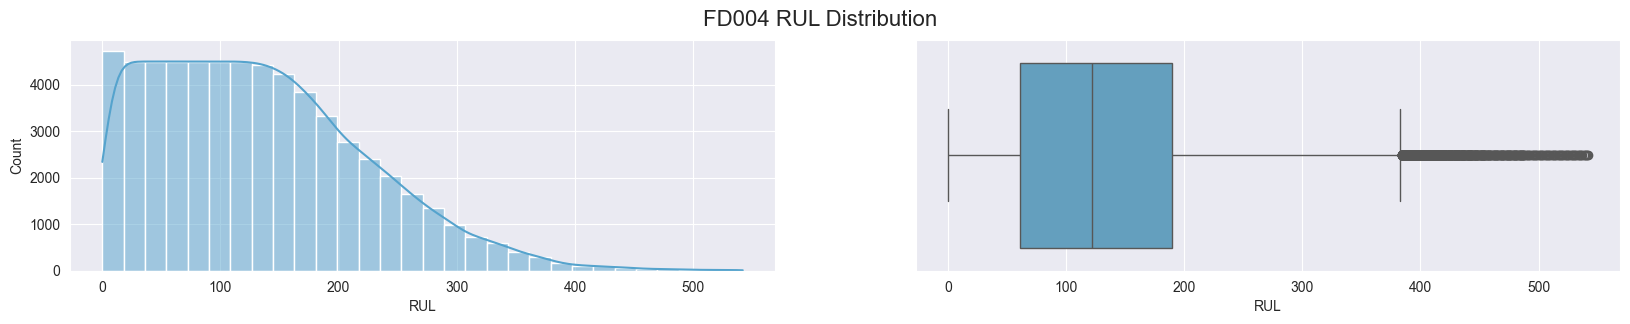

In [79]:
 # Plotting the distribution of RUL
for name , df in train_dfs.items():
    fig, ax = plt.subplots( nrows=1, ncols =2 , figsize=(20,3) )
    ax.flatten()
    
    sns.histplot(x = df['RUL'] , kde = True , bins = 30 ,ax = ax[0])
    sns.boxplot(x = df['RUL'] , ax = ax[1])

    plt.suptitle(f"{name} RUL Distribution" , fontsize = 16 )
    plt.show()

The distribution of the newly created RUL column is right-skewed, closely resembling the distribution of the actual RUL provided in the test data. Most engines have a Remaining Useful Life within the range of 0–150 cycles, while only a few engines extend significantly beyond this range.
Since a noticeable change in RUL is observed primarily after ~100–150 cycles , the RUL will be capped at approximately 135 cycles. This capping ensures that extreme values do not distort the learning process, while still preserving the meaningful degradation patterns present in the majority of engines.

We will then try to remove columns with a low variability.

In [90]:
 # Getting the last cycle in the test columns
test_dfs_last = {}
for name , df in test_dfs.items():
    df = df.groupby('engine_id').tail(1).reset_index(drop = True )
    test_dfs_last[name] = df


In [93]:
 # combining the Tue RUL
test_dfs_RUL = {}
for (name1 , df1) , (name2 , df2) in zip(test_dfs_last.items(),RUL_dfs.items()):
    df = pd.merge( df1, df2, left_index=True, right_index=True )
    df.rename( columns = {'RUL': 'TRUE_RUL'}, inplace = True )
    test_dfs_RUL[name1] = df

In [95]:
 # Capping at 135
capped_dfs = {}

def cap_column(df, col, threshold=135):
    df[col] = np.where(df[col] > threshold, threshold, df[col])
    return df

# Apply to all train_dfs
for name1, df1 in train_dfs.items():
    capped_dfs[name1] = cap_column(df1, 'RUL', threshold=135)


In [96]:
threshold = 0.01 
cleaned_train_dfs = {}
cleaned_test_dfs = {}
dropped_columns = {}

for name , df in capped_dfs.items():

    variances = df.var()
    
    # Keep only columns above threshold
    kept_cols = variances[variances > threshold].index
    
    cleaned_df = df[kept_cols]
    cleaned_train_dfs[name] = cleaned_df
    
    print(f"=== Train {name} ===")
    print("Dropped columns:", list(set(df.columns) - set(kept_cols)))
    dropped_columns[name] = list(set(df.columns) - set(kept_cols))
    print("Dropped columns Number :", len(list(set(df.columns) - set(kept_cols))))
    print("Remaining columns:", list(kept_cols))
    print("Shape:", cleaned_df.shape)
    print("-----" * 60)

 # Dropping in the test data 
for name, df in test_dfs_RUL.items():
    lists = dropped_columns[name]
    df = df.drop( columns = lists )
    cleaned_test_dfs[name] = df
    print(f"=== Test {name} ===")
    print('Dropped_columns: ', lists )
    print('Dropped_columns number: ', len(lists))
    print("Shape:", df.shape)
    print("-----" * 60)

=== Train FD001 ===
Dropped columns: ['sensor_measurement_13', 'sensor_measurement_15', 'sensor_measurement_10', 'sensor_measurement_19', 'operational_setting_2', 'sensor_measurement_18', 'sensor_measurement_6', 'sensor_measurement_16', 'sensor_measurement_5', 'sensor_measurement_1', 'operational_setting_3', 'operational_setting_1', 'sensor_measurement_8']
Dropped columns Number : 13
Remaining columns: ['engine_id', 'cycle', 'sensor_measurement_2', 'sensor_measurement_3', 'sensor_measurement_4', 'sensor_measurement_7', 'sensor_measurement_9', 'sensor_measurement_11', 'sensor_measurement_12', 'sensor_measurement_14', 'sensor_measurement_17', 'sensor_measurement_20', 'sensor_measurement_21', 'RUL']
Shape: (20631, 14)
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


After removing low-variability columns, the datasets retained different numbers of features:

* **FD001:** 13 columns were dropped, leaving 14 columns.
* **FD002:** 1 columns were dropped, leaving 26 columns.
* **FD003:** 11 columns were dropped, leaving 16 columns.
* **FD004:** 1 columns were dropped, leaving 26 columns.

This variation highlights the differences in feature relevance across datasets, with FD001 and FD003 showing a larger proportion of low-variability features compared to FD002 and FD004.

We will then Scale the data to improve model performance. Since the EDA showed that most columns are normally distributed but are skewed, we will apply a log transformation to reduce skew and stabilize variance but  alternative scaling techniques  will also be used to compare model performance under different transformations and identify the most optimal approach.


After scaling and preparing the data, the next step is to develop predictive models for Remaining Useful Life (RUL).

In [98]:
 # saving the datasets in json files
for name, df in cleaned_train_dfs.items():
    df.to_csv( 'cleaned_train '+name+' with RUL.csv', index = False )

for name, df in cleaned_test_dfs.items():
    df.to_csv( 'cleaned_test '+name+' with RUL.csv', index = False )

for name, df in train_dfs.items():
    df.to_csv( 'train '+name+' with RUL.csv', index = False )

for name, df in test_dfs_RUL.items():
    df.to_csv( 'test '+name+' with RUL.csv', index = False )